# 目的
- チョコボールの個数を推定
- 時期での変化を評価する

In [1]:
import os, sys
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm

import ChocoUtils as cu

In [2]:
sns.set()

# データの取得

In [4]:
data = cu.get_data(db_file='choco-ball.db', filter_str='best_before is not NULL')
data = data.drop(columns=['shop', 'factory', 'buyer', 'prd_number', 'campaign'])

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE best_before is not NULL;
Shape of MeasurementData(record_num, n_columns) : (516, 14)


## 前処理（クレンジング）

In [6]:
# ピーナッツ味だけに絞る
df_data = data[data['taste']==0]
# 外れ値（多分記録ミス）を除外
df_data = df_data[-df_data['best_before'].isin(['2018-02-01'])]

print(data.shape)
print(df_data.shape)

(516, 9)
(371, 9)


In [8]:
df_data['bb_date'] = pd.to_datetime(df_data['best_before'])
df_data['bb_year'] = [x.strftime('%Y') for x in df_data['bb_date']]
df_data['bb_month'] = [x.strftime('%m') for x in df_data['bb_date']]
df_data['bb_ym'] = [x.strftime('%Y/%m') for x in df_data['bb_date']]
df_data.head()

,measure_date,best_before,weight,box_weight,ball_number,angel,taste,net_weight,mean_weight,bb_date,bb_year,bb_month,bb_ym
0,2017-11-21,2018-06-01,34.000,4.815,18,0,0,29.185,1.621389,2018-06-01,2018,06,2018/06
1,2017-11-22,2018-06-01,34.193,4.818,17,0,0,29.375,1.727941,2018-06-01,2018,06,2018/06
2,2017-11-23,2018-06-01,35.344,4.836,16,0,0,30.508,1.906750,2018-06-01,2018,06,2018/06
3,2017-11-23,2018-06-01,34.031,4.836,18,0,0,29.195,1.621944,2018-06-01,2018,06,2018/06
4,2017-11-23,2018-06-01,34.198,4.834,18,0,0,29.364,1.631333,2018-06-01,2018,06,2018/06


## データの可視化

In [9]:
date_list = list(set(df_data['bb_ym']))
date_list.sort()

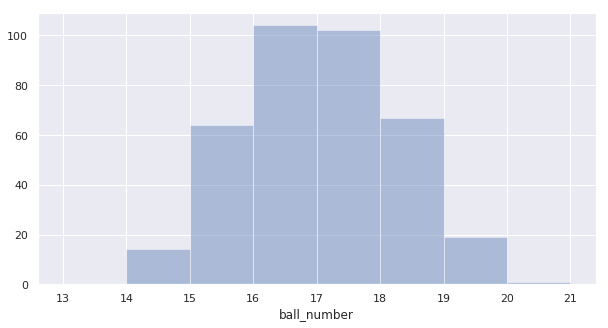

In [10]:
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(1, 1)

ax = sns.distplot(df_data['ball_number'], kde=False, 
                  bins=np.arange(13,22, 1), ax=ax)
plt.savefig('n_ball_hist_all.png')

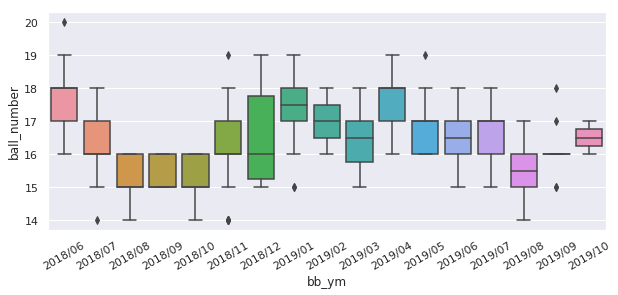

In [12]:
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)

ax = sns.boxplot(x="bb_ym", y="ball_number", data=df_data, 
                 order=date_list, ax=ax)
ret = ax.set_xticklabels(date_list, rotation=30)

plt.savefig('n_ball_bplot_all.png')

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)

date_list2 = list(set(df_data['bb_month']))
date_list2.sort()
ax = sns.boxplot(x="bb_month", y="ball_number", data=df_data, 
                 order=date_list2, ax=ax)
ret = ax.set_xticklabels(date_list2, rotation=30)

In [ ]:
from collections import deque

items = deque(date_list2)
items.rotate(2)

fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)

date_list2 = list(set(df_data['bb_month']))
date_list2.sort()
ax = sns.boxplot(x="bb_month", y="ball_number", data=df_data, 
                 order=items, ax=ax)
ret = ax.set_xticklabels(items, rotation=30)

# 個数の推定

In [13]:
n_balls = df_data['ball_number'].values
#month_s = df_data['bb_month'].values
month_s = df_data['bb_ym'].values
month_idx = pd.Categorical(month_s).codes
month_cat = pd.Categorical(month_s).categories

trans = 3

## 独立に個数の分布を推定

In [ ]:
# ポアソン分布のパラメータを独立に推定
with pm.Model() as model_iso:
    lami = pm.Gamma('lambda', alpha=2.0, beta=1.0/10.0, shape=len(month_cat))
    #lami = pm.Exponential("lambda", lam=0.1, shape=len(month_cat))
    
    y = pm.Poisson('y', mu=lami[month_idx], observed=n_balls)
    
    trace_iso = pm.sample(5000, chains=3)
pm.traceplot(trace_iso)

In [ ]:
month_cat1 = ['2018/08', '2018/09', '2018/10', '2019/08', '2019/09', '2019/10']
month_cat2 = [m for m in month_cat if m not in month_cat1]

fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(2, 1, sharex=True)

for i, m in enumerate(month_cat):
    if m in month_cat1:
        sns.distplot(trace_iso['lambda'][:,i], ax=ax[0], label=month_cat[i])
    else:
        sns.distplot(trace_iso['lambda'][:,i], ax=ax[1], label=month_cat[i])
ax[0].legend()
ax[1].legend()

## 階層ベイズモデルとして推定

In [ ]:
# 階層ベイズモデルとして推定
with pm.Model() as model_h1:
    # hyper-prior
    #a = pm.HalfCauchy('alpha', beta=25)
    #b = pm.HalfCauchy('beta', beta=25)
    #a = pm.Uniform('alpha', lower=0.0, upper=100.0)
    #b = pm.Uniform('beta', lower=0.0, upper=100.0)
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)
    sigma = pm.Exponential('sigma', 1.0)
    a =  mu**2/sigma**2
    b = mu/sigma**2
    # prior
    lami = pm.Gamma('lambda', alpha=a, beta=b, shape=len(month_cat))
    # likelihood
    y = pm.Poisson('y', mu=lami[month_idx], observed=n_balls)
    # sample
    trace_h1 = pm.sample(5000, chains=2)
pm.traceplot(trace_h1)

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(2, 1, sharex=True)

for i in np.arange(0, len(month_cat)):
    if i < trans:
        sns.distplot(trace_h1['lambda'][:,i], ax=ax[0], label=month_cat[i])
    else:
        sns.distplot(trace_h1['lambda'][:,i], ax=ax[1], label=month_cat[i])
ax[0].legend()
ax[1].legend()

In [ ]:
# 階層事前分布を可視化
x = np.linspace(0, 30, 100)
for i in np.random.randint(0, len(trace_h1), size=100):
    mu = trace_h1['mu'][i]
    sigma = trace_h1['sigma'][i]
    a =  mu**2/sigma**2
    b = mu/sigma**2
    pdf = stats.gamma(a=a, scale=1/b).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

mu = trace_h1['mu'].mean()
sigma = trace_h1['sigma'].mean()
a =  mu**2/sigma**2
b = mu/sigma**2
dist = stats.gamma(a=a, scale=1/b)
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))

plt.legend(fontsize=14)
plt.xlabel('$\\lambda_{prior}$', fontsize=16)
plt.tight_layout()

## 階層ベイズ、その1−1
- 事前分布をガンマ分布ではなく、指数分布にしてみた

In [ ]:
# 階層ベイズモデルとして推定
with pm.Model() as model_h1_2:
    ### exponential prior
    a = pm.HalfCauchy('alpha', beta=25)
    lami = pm.Exponential("lambda", lam=a, shape=len(month_cat))
    # likelihood
    y = pm.Poisson('y', mu=lami[month_idx], observed=n_balls)
    # sample
    trace_h1_2 = pm.sample(5000, chains=2)
pm.traceplot(trace_h1_2)

In [ ]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(2, 1, sharex=True)

for i in np.arange(0, len(month_cat)):
    if i < trans:
        sns.distplot(trace_h1_2['lambda'][:,i], ax=ax[0], label=month_cat[i])
    else:
        sns.distplot(trace_h1_2['lambda'][:,i], ax=ax[1], label=month_cat[i])
ax[0].legend()
ax[1].legend()

In [ ]:
# 階層事前分布を可視化
x = np.linspace(0, 1, 100)
for i in np.random.randint(0, len(trace_h1_2), size=100):
    pdf = stats.expon(scale=trace_h1_2['alpha'][i]).pdf(x)
    plt.plot(x, pdf,  'C1', alpha=0.2)

dist = stats.expon(scale=trace_h1_2['alpha'].mean())
pdf = dist.pdf(x)
mode = x[np.argmax(pdf)]
mean = dist.moment(1)
plt.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))

plt.legend(fontsize=14)
plt.xlabel('$\\lambda_{prior}$', fontsize=16)
plt.tight_layout()

## 階層ベイズ、その２
- 違いの出そうな月をあらかじめ分けてそれぞれ推定

In [14]:
month_cat

Index(['2018/06', '2018/07', '2018/08', '2018/09', '2018/10', '2018/11',
       '2018/12', '2019/01', '2019/02', '2019/03', '2019/04', '2019/05',
       '2019/06', '2019/07', '2019/08', '2019/09', '2019/10'],
      dtype='object')

In [15]:
#month_cat1 = month_cat[:trans].values
#month_cat2 = month_cat[trans:].values
month_cat1 = ['2018/08', '2018/09', '2018/10', '2019/08', '2019/09', '2019/10']
month_cat2 = [m for m in month_cat if m not in month_cat1]

df_data1 = df_data[df_data['bb_ym'].isin(month_cat1)]
df_data2 = df_data[df_data['bb_ym'].isin(month_cat2)]
n_balls1 = df_data1['ball_number'].values
n_balls2 = df_data2['ball_number'].values
month_s1 = df_data1['bb_ym'].values
month_s2 = df_data2['bb_ym'].values
month_idx1 = pd.Categorical(month_s1).codes
month_idx2 = pd.Categorical(month_s2).codes

In [16]:
with pm.Model() as model_h2_1:
    # hyper-prior
    #a = pm.HalfCauchy('alpha', beta=25)
    #b = pm.HalfCauchy('beta', beta=25)
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)
    sigma = pm.Exponential('sigma', 1.0)
    a =  mu**2/sigma**2
    b = mu/sigma**2
    # prior
    lami = pm.Gamma('lambda', alpha=a, beta=b, shape=len(month_cat1))
    # likelihood
    y = pm.Poisson('y', mu=lami[month_idx1], observed=n_balls1)
    # sample
    trace_h2_1 = pm.sample(5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [lambda, sigma, mu]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:18<00:00, 609.41draws/s]
There were 213 divergences after tuning. Increase `target_accept` or reparameterize.
There were 312 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


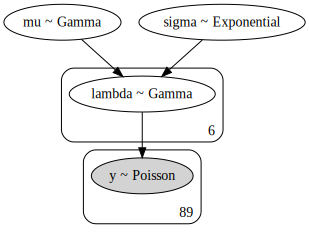

In [38]:
pm.model_to_graphviz(model_h2_1)

In [17]:
with pm.Model() as model_h2_2:
    # hyper-prior
    #a = pm.HalfCauchy('alpha', beta=25)
    #b = pm.HalfCauchy('beta', beta=25)
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5)
    sigma = pm.Exponential('sigma', 1.0)
    a =  mu**2/sigma**2
    b = mu/sigma**2
    # prior
    lami = pm.Gamma('lambda', alpha=a, beta=b, shape=len(month_cat2))
    # likelihood
    y = pm.Poisson('y', mu=lami[month_idx2], observed=n_balls2)
    # sample
    trace_h2_2 = pm.sample(5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [lambda, sigma, mu]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:44<00:00, 245.84draws/s]
There were 360 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6883589040311685, but should be close to 0.8. Try to increase the number of tuning steps.
There were 116 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9311088653705738, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


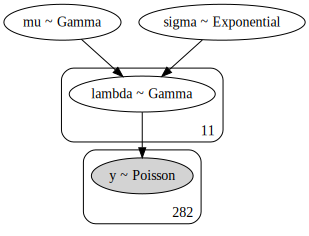

In [40]:
pm.model_to_graphviz(model_h2_2)

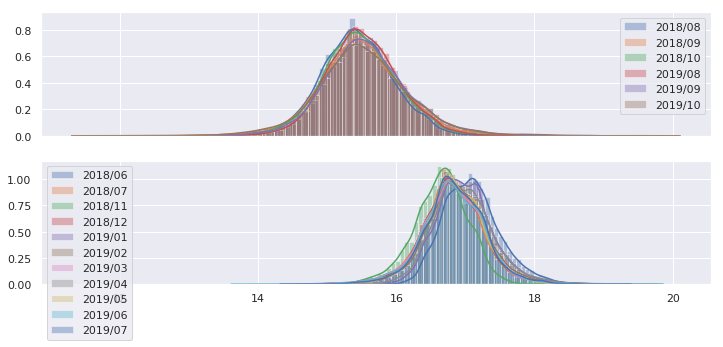

In [18]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(2, 1, sharex=True)

for i in np.arange(0, len(month_cat1)):
    sns.distplot(trace_h2_1['lambda'][:,i], ax=ax[0], label=month_cat1[i])
for i in np.arange(0, len(month_cat2)):
    sns.distplot(trace_h2_2['lambda'][:,i], ax=ax[1], label=month_cat2[i])
ax[0].legend()
ax[1].legend()

In [19]:
def plot_prior(trace, ax):
    # 階層事前分布を可視化
    x = np.linspace(10, 30, 100)
    for i in np.random.randint(0, len(trace), size=100):
        mu = trace['mu'][i]
        sigma = trace['sigma'][i]
        a =  mu**2/sigma**2
        b = mu/sigma**2
        pdf = stats.gamma(a=a, scale=1/b).pdf(x)
        #pdf = stats.gamma(trace['alpha'][i], trace['beta'][i]).pdf(x)
        ax.plot(x, pdf,  'C1', alpha=0.2)
    mu = trace['mu'].mean()
    sigma = trace['sigma'].mean()
    a =  mu**2/sigma**2
    b = mu/sigma**2
    dist = stats.gamma(a=a, scale=1/b)
    #dist = stats.gamma(trace['alpha'].mean(), trace['beta'].mean())
    pdf = dist.pdf(x)
    mode = x[np.argmax(pdf)]
    mean = dist.moment(1)
    ax.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))
    plt.xlabel('$\\lambda_{prior}$', fontsize=16)
    plt.tight_layout()

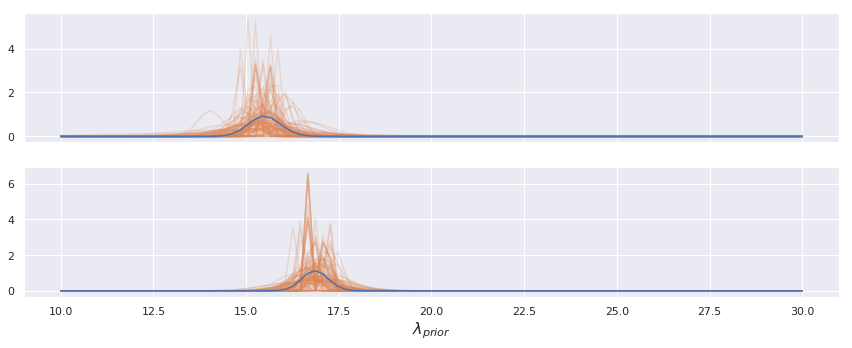

In [20]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(2, 1, sharex=True)

plot_prior(trace_h2_1, ax[0])
plot_prior(trace_h2_2, ax[1])

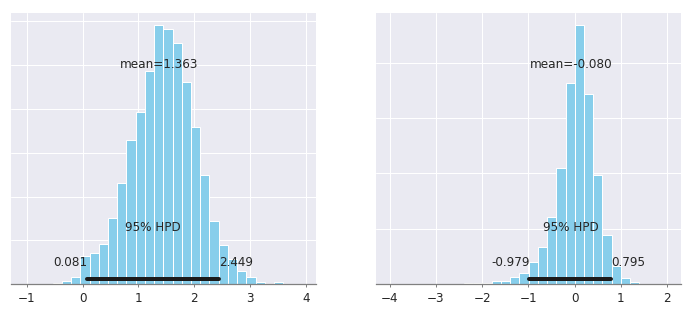

In [21]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
pm.plot_posterior(trace_h2_2['mu']-trace_h2_1['mu'], ax=ax[0])
pm.plot_posterior(trace_h2_2['sigma']-trace_h2_1['sigma'], ax=ax[1])

## 階層ベイズ、その2−2
- その２のモデルを一つで記入

In [43]:
n_balls = df_data['ball_number'].values
#month_s = df_data['bb_month'].values
month_s = df_data['bb_ym'].values
month_idx = pd.Categorical(month_s).codes
month_cat = pd.Categorical(month_s).categories

In [62]:
with pm.Model() as model_h2_1:
    # hyper-prior
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/5, shape=2)
    sigma = pm.Exponential('sigma', 1.0, shape=2)
    a_1 =  mu[0]**2/sigma[0]**2
    b_1 = mu[0]/sigma[0]**2
    a_2 =  mu[1]**2/sigma[1]**2
    b_2 = mu[1]/sigma[1]**2
    a = pm.math.switch([m in month_cat1 for m in month_cat], a_1, a_2)
    b = pm.math.switch([m in month_cat1 for m in month_cat], b_1, b_2)
    # prior
    lami = pm.Gamma('lambda', alpha=a, beta=b, shape=len(month_cat))
    # likelihood
    y = pm.Poisson('y', mu=lami[month_idx], observed=n_balls)
    # sample
    trace_h2_1 = pm.sample(5000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [lambda, sigma, mu]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:24<00:00, 441.35draws/s]
There were 774 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5977336620395443, but should be close to 0.8. Try to increase the number of tuning steps.
There were 998 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5951294998978314, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x131c07518>,
      dtype=object)

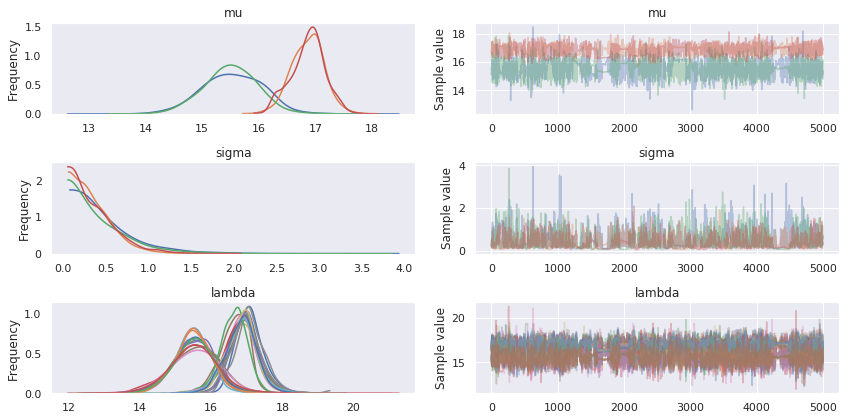

In [63]:
pm.traceplot(trace_h2_1)

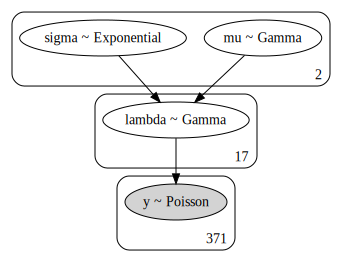

In [92]:
ret = pm.model_to_graphviz(model_h2_1)
ret.render(filename='n_ball_model_01', format='png')
ret

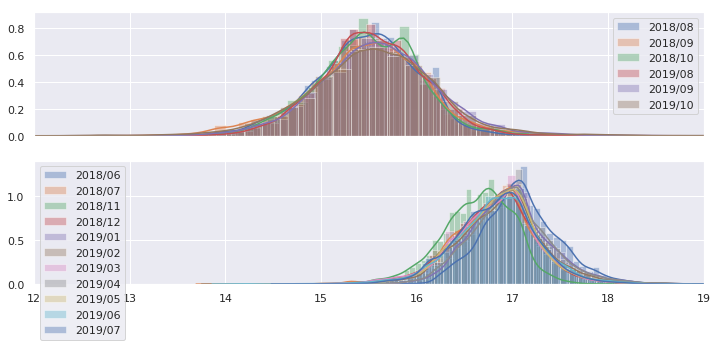

In [93]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(2, 1, sharex=True)

for i, m in enumerate(month_cat):
    if m in month_cat1:
        sns.distplot(trace_h2_1['lambda'][:,i], ax=ax[0], label=m)
    else:
        sns.distplot(trace_h2_1['lambda'][:,i], ax=ax[1], label=m)
ax[0].legend()
ax[1].legend()
ax[1].set_xlim(12, 19)

plt.savefig('n_ball_lambda.png')

In [74]:
def plot_prior(trace_mu, trace_sig, ax):
    # 階層事前分布を可視化
    x = np.linspace(10, 30, 100)
    for i in np.random.randint(0, len(trace_mu), size=100):
        #mu = trace['mu'][i]
        #sigma = trace['sigma'][i]
        mu = trace_mu[i]
        sigma = trace_sig[i]
        a =  mu**2/sigma**2
        b = mu/sigma**2
        pdf = stats.gamma(a=a, scale=1/b).pdf(x)
        #pdf = stats.gamma(trace['alpha'][i], trace['beta'][i]).pdf(x)
        ax.plot(x, pdf,  'C1', alpha=0.2)
    #mu = trace['mu'].mean()
    #sigma = trace['sigma'].mean()
    mu = trace_mu.mean()
    sigma = trace_sig.mean()
    a =  mu**2/sigma**2
    b = mu/sigma**2
    dist = stats.gamma(a=a, scale=1/b)
    #dist = stats.gamma(trace['alpha'].mean(), trace['beta'].mean())
    pdf = dist.pdf(x)
    mode = x[np.argmax(pdf)]
    mean = dist.moment(1)
    ax.plot(x, pdf, label='mode = {:.2f}\nmean = {:.2f}'.format(mode, mean))
    plt.xlabel('$\\lambda_{prior}$', fontsize=16)
    plt.tight_layout()

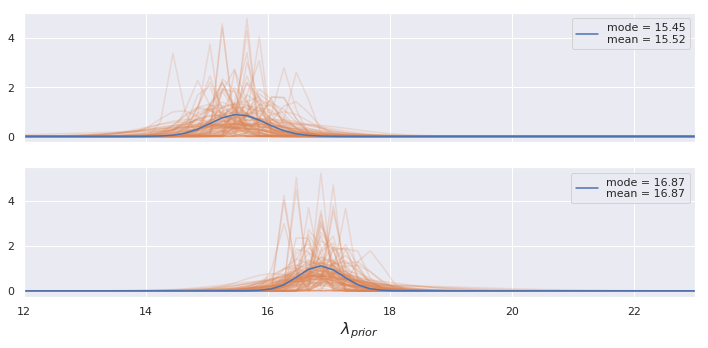

In [94]:
fig = plt.figure(figsize=(10, 5))
ax = fig.subplots(2, 1, sharex=True)

plot_prior(trace_h2_1['mu'][:,0], trace_h2_1['sigma'][:,0], ax[0])
plot_prior(trace_h2_1['mu'][:,1], trace_h2_1['sigma'][:,1], ax[1])
ax[0].legend()
ax[1].legend()
ax[1].set_xlim(12, 23)

plt.savefig('n_ball_gamma.png')

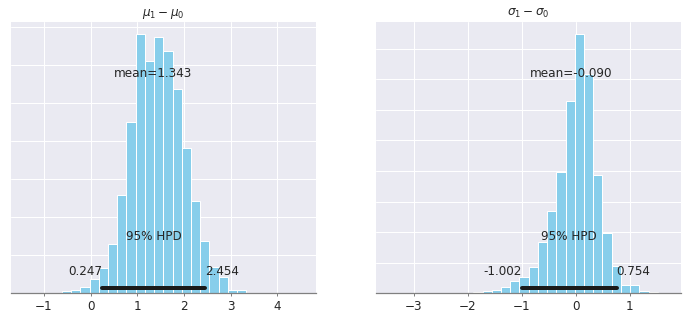

In [97]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(1, 2)
pm.plot_posterior(trace_h2_1['mu'][:,1]-trace_h2_1['mu'][:,0], ax=ax[0])
pm.plot_posterior(trace_h2_1['sigma'][:,1]-trace_h2_1['sigma'][:,0], ax=ax[1])
ax[0].set_title('$\\mu_1 - \\mu_0$')
ax[1].set_title('$\\sigma_1 - \\sigma_0$')

plt.savefig('n_ball_diff_prior.png')

## 階層ベイズ、変化点推定

対象月を絞ったら差異が出た？
```
df_data = df_data[df_data['bb_date']>datetime(2018,7,1,0,0,0)]
df_data = df_data[df_data['bb_date']<datetime(2019,7,1,0,0,0)]
```

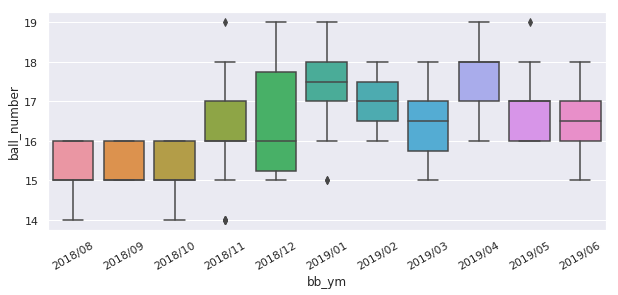

In [28]:
from datetime import datetime
df_data_s = df_data[df_data['bb_date']>datetime(2018,7,1,0,0,0)]
df_data_s = df_data_s[df_data_s['bb_date']<datetime(2019,7,1,0,0,0)]
date_list_s = list(set(df_data_s['bb_ym']))
date_list_s.sort()

fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)
ax = sns.boxplot(x="bb_ym", y="ball_number", data=df_data_s, 
                 order=date_list_s, ax=ax)
ret = ax.set_xticklabels(date_list_s, rotation=30)

In [29]:
# year-month毎
n_balls = df_data_s['ball_number'].values
month_s = df_data_s['bb_ym'].values
month_idx = pd.Categorical(month_s).codes
month_cat = pd.Categorical(month_s).categories

# month毎
#n_balls = df_data['ball_number'].values
#month_s = df_data['bb_month'].values
#month_idx = pd.Categorical(month_s, categories=list(items)).codes
#month_cat = pd.Categorical(month_s, categories=list(items)).categories


In [30]:
month_cat

Index(['2018/08', '2018/09', '2018/10', '2018/11', '2018/12', '2019/01',
       '2019/02', '2019/03', '2019/04', '2019/05', '2019/06'],
      dtype='object')

In [32]:
month_cat_idx = pd.Categorical(month_cat).codes
month_cat_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int8)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [t]
>NUTS: [lambda, sigma, mu]
100%|██████████| 5500/5500 [00:24<00:00, 221.54it/s]
There were 857 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.682084036744708, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12f690518>,
      dtype=object)

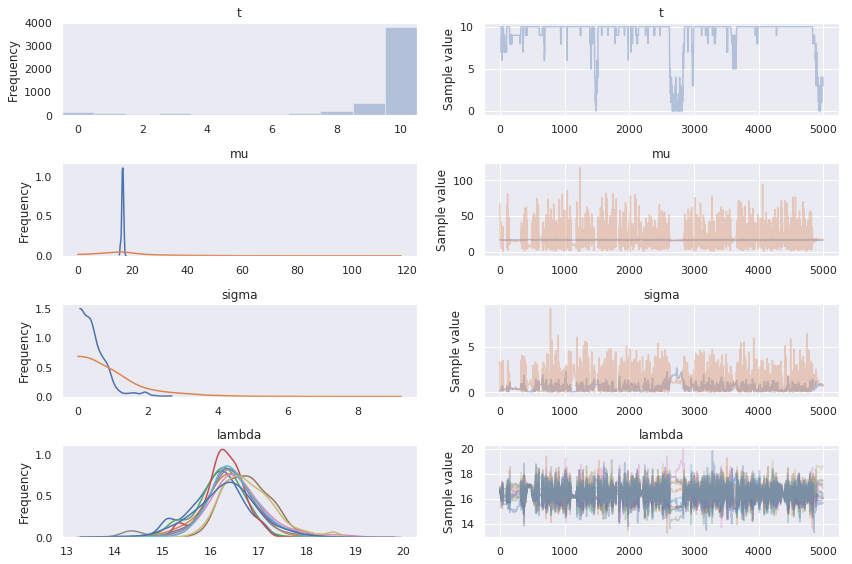

In [36]:
with pm.Model() as model_trans:
    # 変化点
    t = pm.DiscreteUniform('t', lower=0, upper=(len(month_cat)-1))
    # prior
    #a_1 = pm.Exponential('alpha1', lam=1)
    #a_2 = pm.Exponential('alpha2', lam=1)
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/10, shape=2)
    sigma = pm.Exponential('sigma', 1.0, shape=2)
    a_1 =  mu[0]**2/sigma[0]**2
    b_1 = mu[0]/sigma[0]**2
    a_2 =  mu[1]**2/sigma[1]**2
    b_2 = mu[1]/sigma[1]**2
    
    a = pm.math.switch(t >= month_cat_idx, a_1, a_2)
    b = pm.math.switch(t >= month_cat_idx, b_1, b_2)
    lami = pm.Gamma('lambda', alpha=a, beta=b, shape=len(month_cat_idx))
    # likelihood
    y = pm.Poisson('y', mu=lami[month_idx], observed=n_balls)
    # sample
    trace_trans = pm.sample(5000, chains=1)
pm.traceplot(trace_trans)

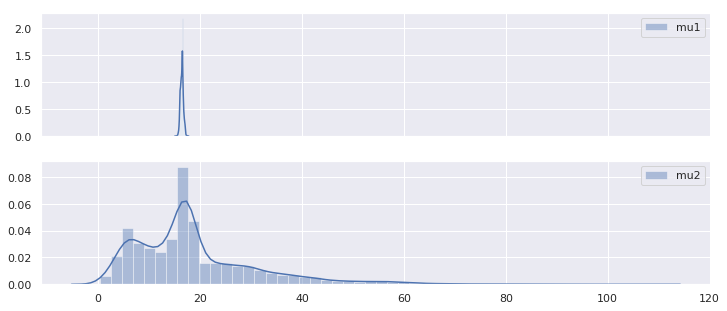

In [34]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(2, 1, sharex=True)

sns.distplot(trace_trans['mu'][:,0], ax=ax[0], label='mu1')
sns.distplot(trace_trans['mu'][:,1], ax=ax[1], label='mu2')
ax[0].legend()
ax[1].legend()

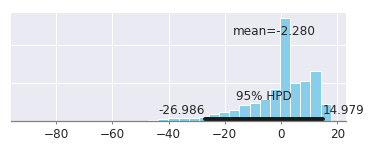

In [35]:
pm.plot_posterior(trace_trans['mu'][:,0]-trace_trans['mu'][:,1])

## 変化点推定その２
- 月単位にしてみる

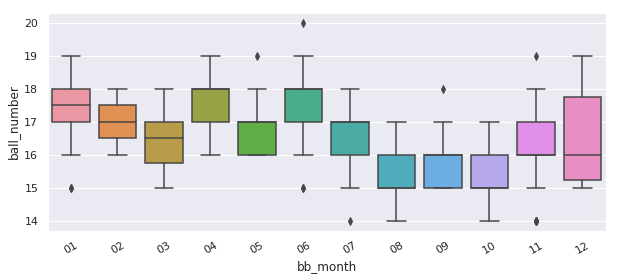

In [22]:
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)

date_list2 = list(set(df_data['bb_month']))
date_list2.sort()
ax = sns.boxplot(x="bb_month", y="ball_number", data=df_data, 
                 order=date_list2, ax=ax)
ret = ax.set_xticklabels(date_list2, rotation=30)

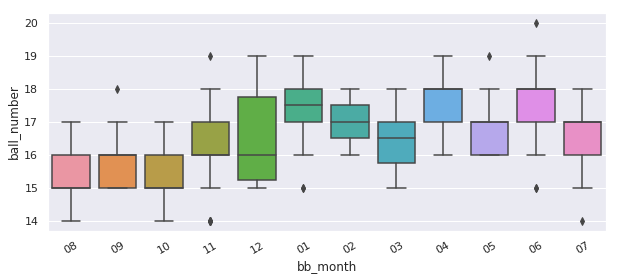

In [23]:
# 変化点を一箇所にするために月をづらす

from collections import deque

items = deque(date_list2)
items.rotate(5)

fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)

date_list2 = list(set(df_data['bb_month']))
date_list2.sort()
ax = sns.boxplot(x="bb_month", y="ball_number", data=df_data, 
                 order=items, ax=ax)
ret = ax.set_xticklabels(items, rotation=30)

In [24]:
# month毎
n_balls = df_data['ball_number'].values
month_tmp = df_data['bb_month'].values
month_idx = pd.Categorical(month_s, categories=list(items)).codes
month_cat = pd.Categorical(month_s, categories=list(items)).categories

In [25]:
month_cat

Index(['08', '09', '10', '11', '12', '01', '02', '03', '04', '05', '06', '07'], dtype='object')

In [26]:
month_cat_idx = pd.Categorical(month_cat, categories=list(items)).codes
month_cat_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int8)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [t]
>NUTS: [lambda, sigma, mu]
100%|██████████| 5500/5500 [00:29<00:00, 187.35it/s]
There were 2112 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.34372113970674284, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129ea99e8>,
      dtype=object)

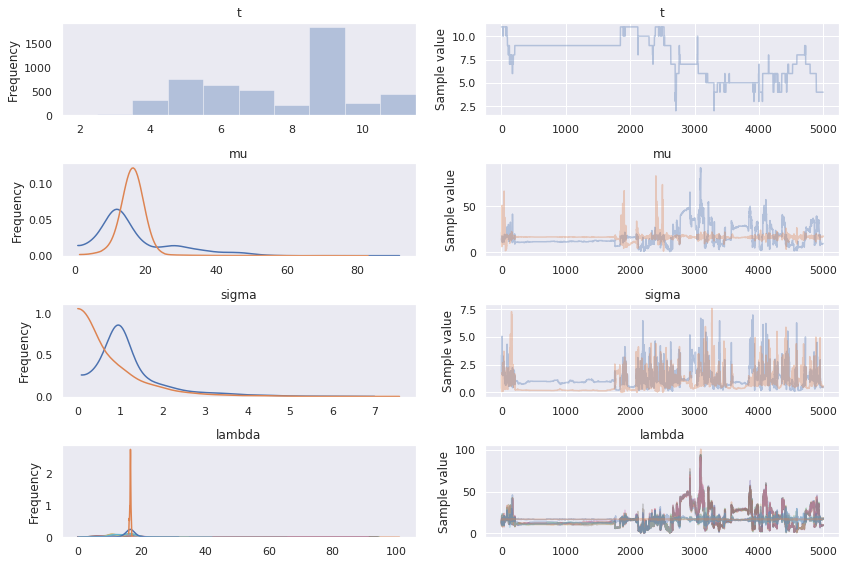

In [27]:
with pm.Model() as model_trans:
    # 変化点
    t = pm.DiscreteUniform('t', lower=0, upper=(len(month_cat)-1))
    # prior
    mu = pm.Gamma('mu', alpha=2.0, beta=1.0/10, shape=2)
    sigma = pm.Exponential('sigma', 1.0, shape=2)
    a_1 =  mu[0]**2/sigma[0]**2
    b_1 = mu[0]/sigma[0]**2
    a_2 =  mu[1]**2/sigma[1]**2
    b_2 = mu[1]/sigma[1]**2
    
    a = pm.math.switch(t >= month_cat_idx, a_1, a_2)
    b = pm.math.switch(t >= month_cat_idx, b_1, b_2)
    lami = pm.Gamma('lambda', alpha=a, beta=b, shape=len(month_cat_idx))
    # likelihood
    y = pm.Poisson('y', mu=lami[month_idx], observed=n_balls)
    # sample
    trace_trans = pm.sample(5000, chains=1)
pm.traceplot(trace_trans)